In [1]:
import json
from math import sin, cos
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import cv2
import os

In [105]:
with open("/disks/hdd/pku-autonomous-driving/JSON/train_objects_bbox.json", "r") as f:
    coco_gt = json.load(f)

In [106]:
coco_gt["annotations"][3]

{'id': 4,
 'image_id': 0,
 'category_id': 77,
 'area': 28350.0,
 'bbox': [973.0, 1796.0, 210.0, 135.0],
 'iscrowd': 0,
 'position': [-8.95864, 7.44172, 34.3233],
 'orientation': [0.0984473, -0.0698146, -3.09571]}

In [44]:
coco_gt["images"][0]

{'id': 0, 'width': 3384, 'height': 2710, 'file_name': 'ID_001a12fb2.jpg'}

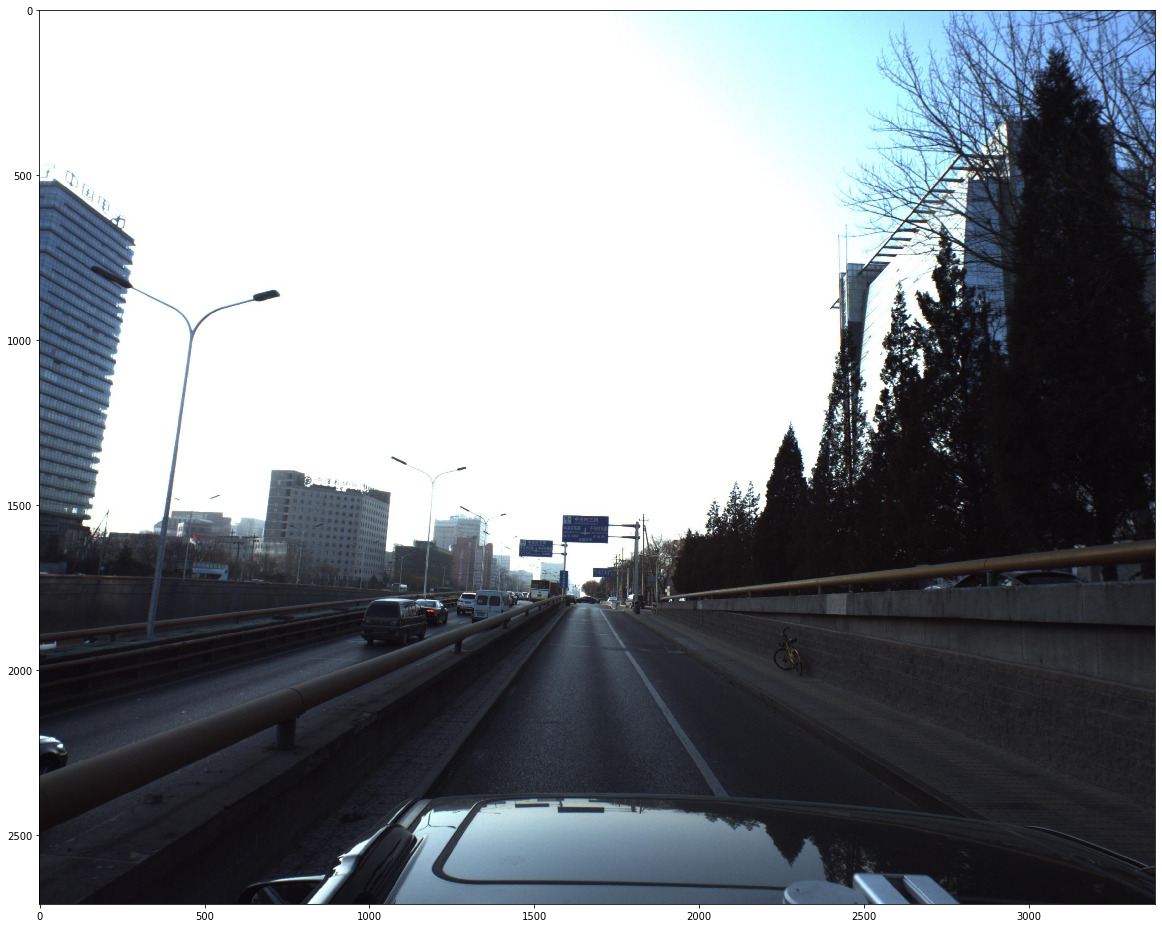

In [45]:
# Load an image
img_name = 'ID_001a12fb2'  # 'ID_0a0980d15'
img = cv2.imread(f'/disks/hdd/pku-autonomous-driving/train_images/{img_name}.jpg',cv2.COLOR_BGR2RGB)[:,:,::-1]
plt.figure(figsize=(20, 20))
plt.imshow(img);

In [46]:
roi = np.array([973.0, 1796.0, 210.0, 135.0])

In [47]:
p1 = (int(roi[0]), int(roi[1]))
p2 = (int(roi[0] + roi[2]), int(roi[1] + roi[3]))

In [48]:
p1, p2

((973, 1796), (1183, 1931))

In [49]:
image = cv2.rectangle(img, p1, p2, (255, 255, 255), 3).get()

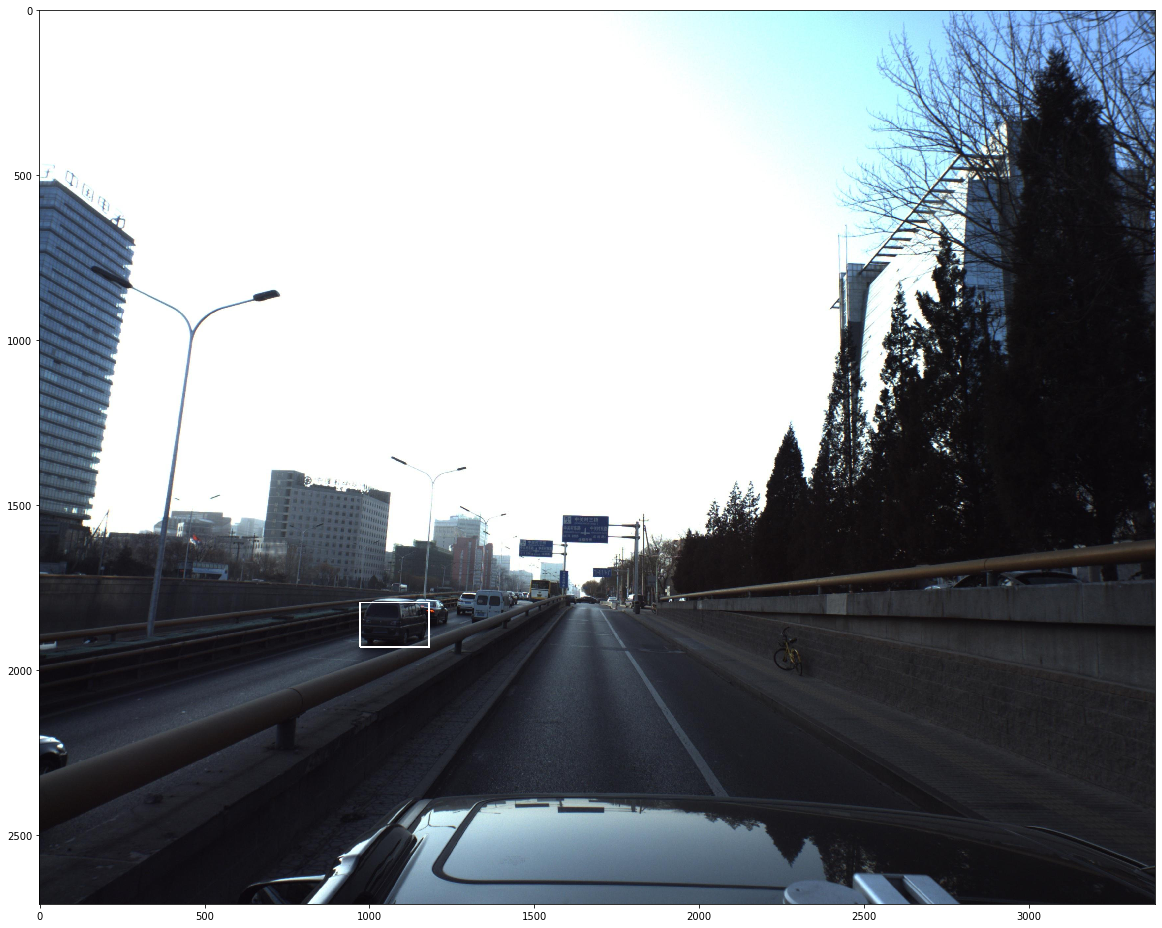

In [50]:
plt.figure(figsize=(20, 20))
plt.imshow(image);

In [51]:
k = np.array([[2304.5479, 0,  1686.2379],
           [0, 2305.8757, 1354.9849],
           [0, 0, 1]], dtype=np.float32)

In [175]:
def calibration_matrix(roi, camera_matrix):
    inv_camera_matrix = np.linalg.inv(camera_matrix)
    x, y, w, h = roi
    cx, cy = x + w / 2, y + h / 2
    v2 = np.array([cx, cy, 1])
    v3 = inv_camera_matrix.dot(v2)
    tg_ay, tg_ax, _ = v3
    ax = np.arctan(tg_ax)
    ay = -np.arctan(tg_ay)
    Mx = np.array([[1, 0, 0], [0, np.cos(ax), -np.sin(ax)], [0, np.sin(ax), np.cos(ax)]])
    My = np.array([[np.cos(ay), 0, np.sin(ay)], [0, 1, 0], [-np.sin(ay), 0, np.cos(ay)]])
    M = camera_matrix.dot(Mx).dot(My).dot(inv_camera_matrix)
    return M

def calibrate_roi(roi, M):
    x, y, w, h = roi
    P = np.array([
        [x, y, 1],
        [x + w, y, 1],
        [x + w, y + h, 1],
        [x, y + h, 1]
    ])
    P_new = M.dot(P.T).T
    P_new /= P_new[:, 2:]
    x_new = P_new[:, 0].min()
    y_new = P_new[:, 1].min()
    w_new = P_new[:, 0].max() - x_new
    h_new = P_new[:, 1].max() - y_new
    return [x_new, y_new, w_new, h_new]

def crop_calbrated(image, roi, camera_matrix):
    H, W = image.shape[:2]
    M = calibration_matrix(roi, camera_matrix)
    print(M)
    image_new = cv2.warpPerspective(image, M, (W, H))
    roi_new = calibrate_roi(roi, M)
    return image_new, roi_new

In [ ]:
def Rot_to_yaw(Y):
    cos = Y[0, 0]
    sin = Y[0, 2]
    return np.arctan2(sin, cos)


def Rot_to_pitch(P):
    cos = P[1, 1]
    sin = P[2, 1]
    return np.arctan2(sin, cos)


def Rot_to_roll(R):
    cos = R[0, 0]
    sin = R[1, 0]
    return np.arctan2(sin, cos)

In [104]:
from scipy.spatial.transform import Rotation as R

In [112]:
rot = R.from_euler("YXZ", [0.0984473, -0.0698146, -3.09571])

In [123]:
rot.as_dcm().T

array([[-0.99379617, -0.04575482,  0.10136898],
       [ 0.05249364, -0.99651409,  0.06483892],
       [ 0.09804892,  0.0697579 ,  0.99273372]])

In [124]:
np.linalg.inv(rot.as_dcm())

array([[-0.99379617, -0.04575482,  0.10136898],
       [ 0.05249364, -0.99651409,  0.06483892],
       [ 0.09804892,  0.0697579 ,  0.99273372]])

In [114]:
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([
        [ cos(yaw), 0, sin(yaw)],
        [        0, 1,        0],
        [-sin(yaw), 0, cos(yaw)]
    ])
    P = np.array([
        [1,          0,           0],
        [0, cos(pitch), -sin(pitch)],
        [0, sin(pitch),  cos(pitch)]
    ])
    R = np.array([
        [cos(roll), -sin(roll), 0],
        [sin(roll),  cos(roll), 0],
        [        0,          0, 1]
    ])
    return np.dot(Y, np.dot(P, R))

In [115]:
euler_to_Rot(0.0984473, -0.0698146, -3.09571)

array([[-0.99379617,  0.05249364,  0.09804892],
       [-0.04575482, -0.99651409,  0.0697579 ],
       [ 0.10136898,  0.06483892,  0.99273372]])

In [117]:
rot.as_euler("YXZ")

array([ 0.0984473, -0.0698146, -3.09571  ])

In [191]:
def calibration_matrix(roi, camera_matrix):
    inv_camera_matrix = np.linalg.inv(camera_matrix)
    x, y, w, h = roi
    cx, cy = x + w / 2, y + h / 2
    v2 = np.array([cx, cy, 1])
    v3 = inv_camera_matrix.dot(v2)
    tg_ay, tg_ax, _ = v3
    ax = np.arctan(tg_ax)
    ay = -np.arctan(tg_ay)
    Mx = np.array([[1, 0, 0], [0, np.cos(ax), -np.sin(ax)], [0, np.sin(ax), np.cos(ax)]])
    My = np.array([[np.cos(ay), 0, np.sin(ay)], [0, 1, 0], [-np.sin(ay), 0, np.cos(ay)]])
    M = camera_matrix.dot(Mx).dot(My).dot(inv_camera_matrix)
    return M, Mx, My

In [194]:
yaw, pitch, roll = 0, 1, 0
_, Mx, My = calibration_matrix([1686.2379 + 500, 1354.9849, 0, 0], k)
rot1 = R.from_euler("YXZ", [yaw, pitch, roll])
rot2 = R.from_dcm(Mx.dot(My.T).T)
yaw_rel, pitch_rel, roll_rel = (rot2 * rot1).as_euler("YXZ")

In [182]:
yaw_rel, pitch_rel, roll_rel

(2.7178785888537513e-09, 1.000000001698063, 3.8273972078070425e-25)

In [195]:
yaw_rel, pitch_rel, roll_rel

(-0.21365100334971232, 1.000000001698063, -2.5685227869270256e-17)

In [93]:
img.shape

(2710, 3384, 3)

In [176]:
img_undistorted, roi_undistorted = crop_calbrated(img, roi, k)

[[ 7.84548849e-01  1.57484946e-01  6.43925234e+02]
 [-9.15332740e-02  1.10308353e+00 -5.41075133e+02]
 [-1.08135315e-04  9.33942622e-05  9.99997339e-01]]


In [120]:
rot2 = R.from_dcm(np.array([
    [ 7.84548849e-01,  1.57484946e-01,  6.43925234e+02],
    [-9.15332740e-02,  1.10308353e+00, -5.41075133e+02],
    [-1.08135315e-04,  9.33942622e-05,  9.99997339e-01]
]))

In [121]:
rot2.as_dcm()

array([[-0.17226377,  0.9850281 ,  0.00669649],
       [ 0.98502262,  0.17230633, -0.00640032],
       [-0.00745834,  0.00549365, -0.9999571 ]])

In [129]:
(rot * rot2).as_dcm()

array([[ 0.22217122, -0.96933352, -0.10503563],
       [-0.9742273 , -0.21639224, -0.06368329],
       [ 0.03900146,  0.11647717, -0.9924273 ]])

In [177]:
p1 = (int(roi_undistorted[0]), int(roi_undistorted[1]))
p2 = (int(roi_undistorted[0] + roi_undistorted[2]), int(roi_undistorted[1] + roi_undistorted[3]))

In [178]:
img_undistorted = cv2.rectangle(img_undistorted, p1, p2, (255, 255, 255), 3)

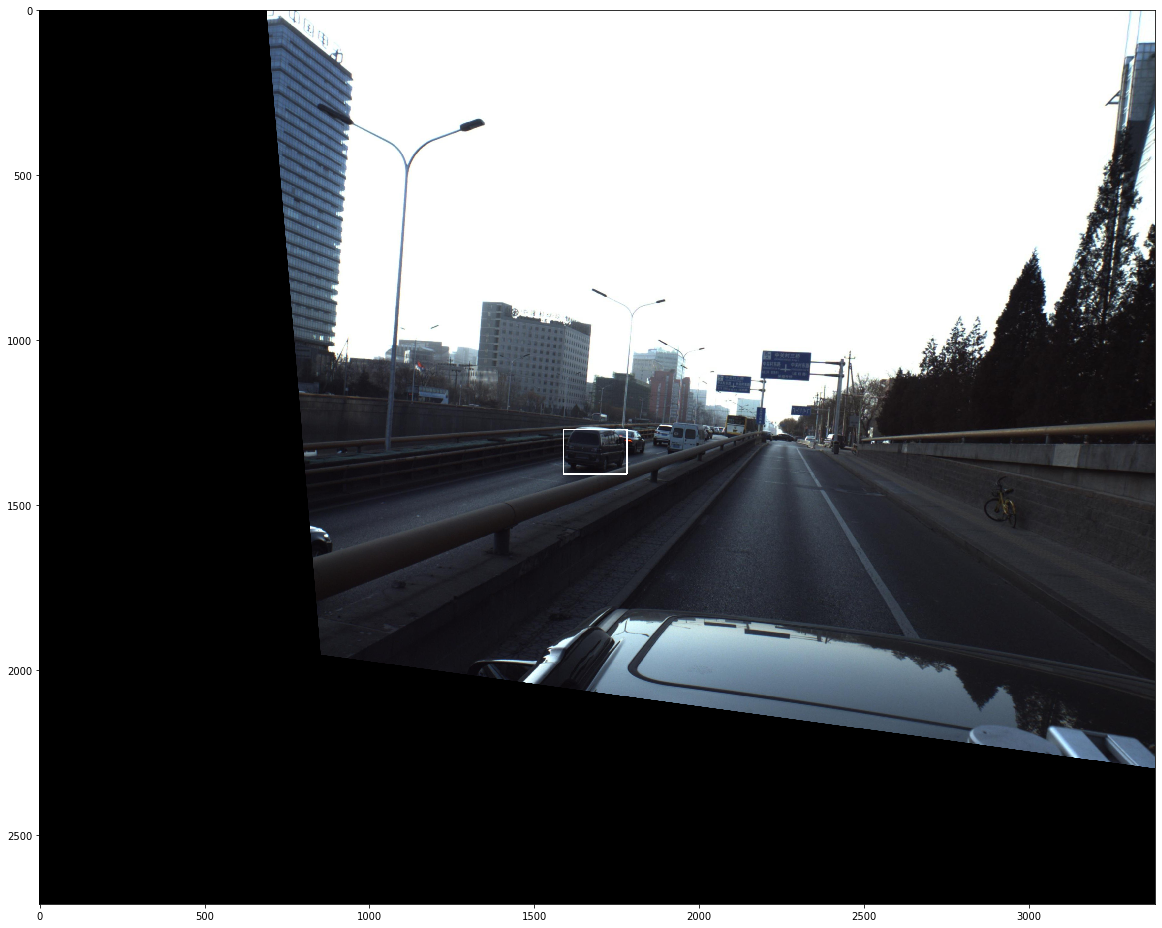

In [179]:
plt.figure(figsize=(20, 20))
plt.imshow(img_undistorted);

In [34]:
(img == img_undistorted).all()

True

In [3]:
train = pd.read_csv('/disks/hdd/pku-autonomous-driving/train.csv')
pred_string = train[train.ImageId == img_name].PredictionString.iloc[0]
items = pred_string.split(' ')
model_types, yaws, pitches, rolls, xs, ys, zs = [items[i::7] for i in range(7)]

In [4]:
# k is camera instrinsic matrix
k = np.array([[2304.5479, 0,  1686.2379],
           [0, 2305.8757, 1354.9849],
           [0, 0, 1]], dtype=np.float32)

# convert euler angle to rotation matrix
def euler_to_Rot(yaw, pitch, roll):
    Y = np.array([[cos(yaw), 0, sin(yaw)],
                  [0, 1, 0],
                  [-sin(yaw), 0, cos(yaw)]])
    P = np.array([[1, 0, 0],
                  [0, cos(pitch), -sin(pitch)],
                  [0, sin(pitch), cos(pitch)]])
    R = np.array([[cos(roll), -sin(roll), 0],
                  [sin(roll), cos(roll), 0],
                  [0, 0, 1]])
    return np.dot(Y, np.dot(P, R))

In [5]:
def draw_obj(image, vertices, triangles):
    for t in triangles:
        coord = np.array([vertices[t[0]][:2], vertices[t[1]][:2], vertices[t[2]][:2]], dtype=np.int32)
#         cv2.fillConvexPoly(image, coord, (0,0,255))
        cv2.polylines(image, np.int32([coord]), 1, (0,0,255))

In [6]:
def draw_segm_mask(mask, vertices, triangles):
    for t in triangles:
        coord = np.array([vertices[t[0]][:2], vertices[t[1]][:2], vertices[t[2]][:2]], dtype=np.int32)
        cv2.fillConvexPoly(mask, coord, 255)

def obj_to_bbox(vertices, triangles):
    xtl, ytl, xbr, ybr = np.inf, np.inf, 0, 0
    for t in triangles:
        coord = np.array([vertices[t[0]][:2], vertices[t[1]][:2], vertices[t[2]][:2]], dtype=np.int32)
        xtl = min(xtl, np.min(coord[:, 0]))
        xbr = max(xbr, np.max(coord[:, 0]))
        ytl = min(ytl, np.min(coord[:, 1]))
        ybr = max(ybr, np.max(coord[:, 1]))
    return xtl, ytl, xbr, ybr

In [7]:
"""
    Brief: Car model summary
    Author: wangpeng54@baidu.com
    Date: 2018/6/10
"""

from collections import namedtuple


#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple('Label', [

    'name'        , # The name of a car type
    'id'          , # id for specific car type
    'category'    , # The name of the car category, 'SUV', 'Sedan' etc
    'categoryId'  , # The ID of car category. Used to create ground truth images
                    # on category level.
    ])


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

models = [
    #     name          id   is_valid  category  categoryId
    Label(             'baojun-310-2017',          0,       '2x',          0),
    Label(                'biaozhi-3008',          1,       '2x',          0),
    Label(          'biaozhi-liangxiang',          2,       '2x',          0),
    Label(           'bieke-yinglang-XT',          3,       '2x',          0),
    Label(                'biyadi-2x-F0',          4,       '2x',          0),
    Label(               'changanbenben',          5,       '2x',          0),
    Label(                'dongfeng-DS5',          6,       '2x',          0),
    Label(                     'feiyate',          7,       '2x',          0),
    Label(         'fengtian-liangxiang',          8,       '2x',          0),
    Label(                'fengtian-MPV',          9,       '2x',          0),
    Label(           'jilixiongmao-2015',         10,       '2x',          0),
    Label(           'lingmu-aotuo-2009',         11,       '2x',          0),
    Label(                'lingmu-swift',         12,       '2x',          0),
    Label(             'lingmu-SX4-2012',         13,       '2x',          0),
    Label(              'sikeda-jingrui',         14,       '2x',          0),
    Label(        'fengtian-weichi-2006',         15,       '3x',          1),
    Label(                   '037-CAR02',         16,       '3x',          1),
    Label(                     'aodi-a6',         17,       '3x',          1),
    Label(                   'baoma-330',         18,       '3x',          1),
    Label(                   'baoma-530',         19,       '3x',          1),
    Label(            'baoshijie-paoche',         20,       '3x',          1),
    Label(             'bentian-fengfan',         21,       '3x',          1),
    Label(                 'biaozhi-408',         22,       '3x',          1),
    Label(                 'biaozhi-508',         23,       '3x',          1),
    Label(                'bieke-kaiyue',         24,       '3x',          1),
    Label(                        'fute',         25,       '3x',          1),
    Label(                     'haima-3',         26,       '3x',          1),
    Label(               'kaidilake-CTS',         27,       '3x',          1),
    Label(                   'leikesasi',         28,       '3x',          1),
    Label(               'mazida-6-2015',         29,       '3x',          1),
    Label(                  'MG-GT-2015',         30,       '3x',          1),
    Label(                       'oubao',         31,       '3x',          1),
    Label(                        'qiya',         32,       '3x',          1),
    Label(                 'rongwei-750',         33,       '3x',          1),
    Label(                  'supai-2016',         34,       '3x',          1),
    Label(             'xiandai-suonata',         35,       '3x',          1),
    Label(            'yiqi-benteng-b50',         36,       '3x',          1),
    Label(                       'bieke',         37,       '3x',          1),
    Label(                   'biyadi-F3',         38,       '3x',          1),
    Label(                  'biyadi-qin',         39,       '3x',          1),
    Label(                     'dazhong',         40,       '3x',          1),
    Label(              'dazhongmaiteng',         41,       '3x',          1),
    Label(                    'dihao-EV',         42,       '3x',          1),
    Label(      'dongfeng-xuetielong-C6',         43,       '3x',          1),
    Label(     'dongnan-V3-lingyue-2011',         44,       '3x',          1),
    Label(    'dongfeng-yulong-naruijie',         45,      'SUV',          2),
    Label(                     '019-SUV',         46,      'SUV',          2),
    Label(                   '036-CAR01',         47,      'SUV',          2),
    Label(                 'aodi-Q7-SUV',         48,      'SUV',          2),
    Label(                  'baojun-510',         49,      'SUV',          2),
    Label(                    'baoma-X5',         50,      'SUV',          2),
    Label(             'baoshijie-kayan',         51,      'SUV',          2),
    Label(             'beiqi-huansu-H3',         52,      'SUV',          2),
    Label(              'benchi-GLK-300',         53,      'SUV',          2),
    Label(                'benchi-ML500',         54,      'SUV',          2),
    Label(         'fengtian-puladuo-06',         55,      'SUV',          2),
    Label(            'fengtian-SUV-gai',         56,      'SUV',          2),
    Label(    'guangqi-chuanqi-GS4-2015',         57,      'SUV',          2),
    Label(        'jianghuai-ruifeng-S3',         58,      'SUV',          2),
    Label(                  'jili-boyue',         59,      'SUV',          2),
    Label(                      'jipu-3',         60,      'SUV',          2),
    Label(                  'linken-SUV',         61,      'SUV',          2),
    Label(                   'lufeng-X8',         62,      'SUV',          2),
    Label(                 'qirui-ruihu',         63,      'SUV',          2),
    Label(                 'rongwei-RX5',         64,      'SUV',          2),
    Label(             'sanling-oulande',         65,      'SUV',          2),
    Label(                  'sikeda-SUV',         66,      'SUV',          2),
    Label(            'Skoda_Fabia-2011',         67,      'SUV',          2),
    Label(            'xiandai-i25-2016',         68,      'SUV',          2),
    Label(            'yingfeinidi-qx80',         69,      'SUV',          2),
    Label(             'yingfeinidi-SUV',         70,      'SUV',          2),
    Label(                  'benchi-SUR',         71,      'SUV',          2),
    Label(                 'biyadi-tang',         72,      'SUV',          2),
    Label(           'changan-CS35-2012',         73,      'SUV',          2),
    Label(                 'changan-cs5',         74,      'SUV',          2),
    Label(          'changcheng-H6-2016',         75,      'SUV',          2),
    Label(                 'dazhong-SUV',         76,      'SUV',          2),
    Label(     'dongfeng-fengguang-S560',         77,      'SUV',          2),
    Label(       'dongfeng-fengxing-SX6',         78,      'SUV',          2)

]


#--------------------------------------------------------------------------------
# Create dictionaries for a fast lookup
#--------------------------------------------------------------------------------

# Please refer to the main method below for example usages!

# name to label object
car_name2id = {label.name: label.id for label in models}
car_id2name = {label.id: label.name for label in models}

#--------------------------------------------------------------------------------
# Main for testing
#--------------------------------------------------------------------------------

In [138]:
car_name2id

{'baojun-310-2017': 0,
 'biaozhi-3008': 1,
 'biaozhi-liangxiang': 2,
 'bieke-yinglang-XT': 3,
 'biyadi-2x-F0': 4,
 'changanbenben': 5,
 'dongfeng-DS5': 6,
 'feiyate': 7,
 'fengtian-liangxiang': 8,
 'fengtian-MPV': 9,
 'jilixiongmao-2015': 10,
 'lingmu-aotuo-2009': 11,
 'lingmu-swift': 12,
 'lingmu-SX4-2012': 13,
 'sikeda-jingrui': 14,
 'fengtian-weichi-2006': 15,
 '037-CAR02': 16,
 'aodi-a6': 17,
 'baoma-330': 18,
 'baoma-530': 19,
 'baoshijie-paoche': 20,
 'bentian-fengfan': 21,
 'biaozhi-408': 22,
 'biaozhi-508': 23,
 'bieke-kaiyue': 24,
 'fute': 25,
 'haima-3': 26,
 'kaidilake-CTS': 27,
 'leikesasi': 28,
 'mazida-6-2015': 29,
 'MG-GT-2015': 30,
 'oubao': 31,
 'qiya': 32,
 'rongwei-750': 33,
 'supai-2016': 34,
 'xiandai-suonata': 35,
 'yiqi-benteng-b50': 36,
 'bieke': 37,
 'biyadi-F3': 38,
 'biyadi-qin': 39,
 'dazhong': 40,
 'dazhongmaiteng': 41,
 'dihao-EV': 42,
 'dongfeng-xuetielong-C6': 43,
 'dongnan-V3-lingyue-2011': 44,
 'dongfeng-yulong-naruijie': 45,
 '019-SUV': 46,
 '036-CAR0

In [8]:
car_id2model = {}
for id_, name in car_id2name.items():
    path = os.path.join("/disks/hdd/pku-autonomous-driving/car_models_json", name + ".json")
    with open(path) as json_file:
        car_id2model[id_] = json.load(json_file)

In [9]:
car_id2vertices = {}
car_id2triangles = {}
for id_, model in car_id2model.items():
    vertices = np.array(model['vertices'])
    vertices[:, 1] = -vertices[:, 1]
    triangles = np.array(model['faces']) - 1
    
    car_id2vertices[id_] = vertices
    car_id2triangles[id_] = triangles

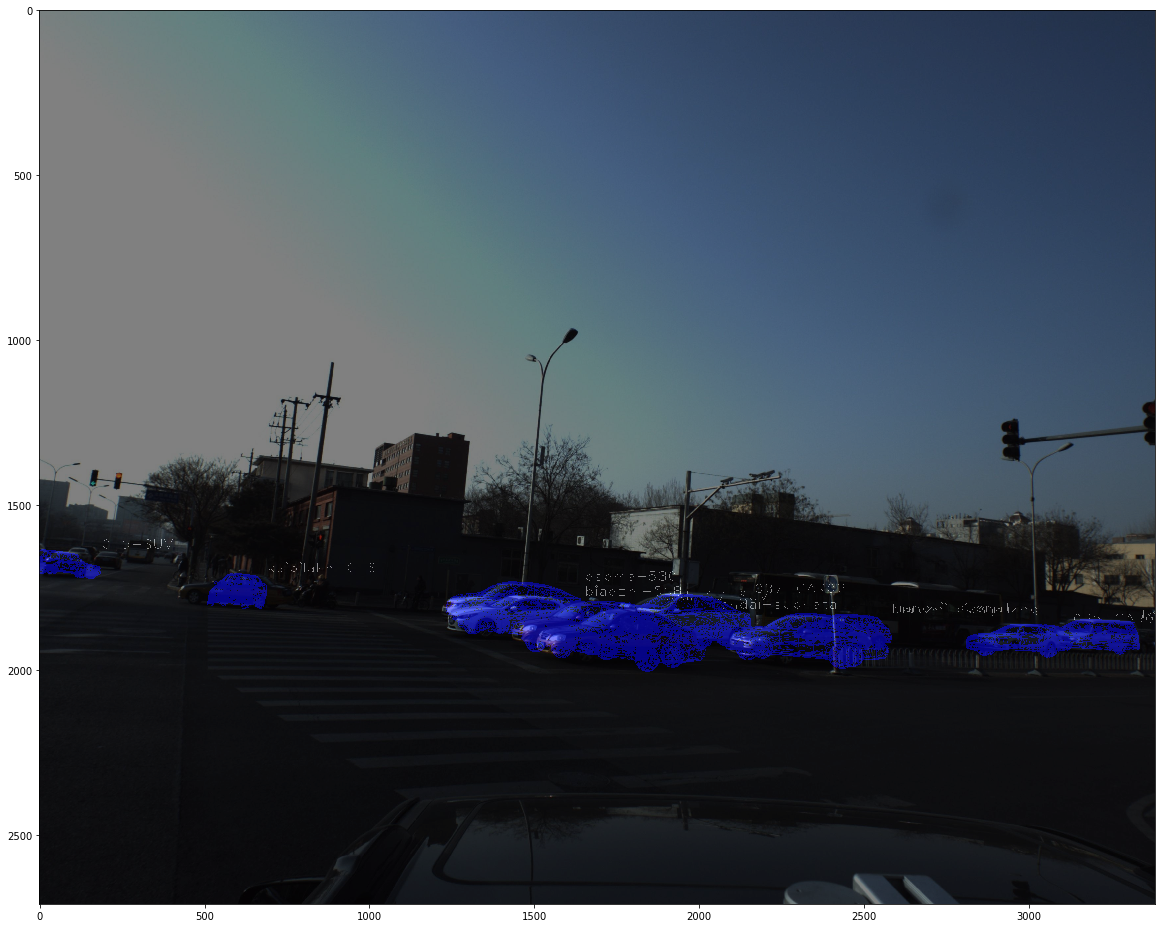

In [29]:
overlay = np.zeros_like(img)
mask = np.zeros(img.shape[:2], dtype=np.uint8)
for model_type, yaw, pitch, roll, x, y, z in zip(model_types, yaws, pitches, rolls, xs, ys, zs):
    model_type = int(model_type)
    vertices = car_id2vertices[model_type]
    triangles = car_id2triangles[model_type]
    yaw, pitch, roll, x, y, z = [float(x) for x in [yaw, pitch, roll, x, y, z]]
    # I think the pitch and yaw should be exchanged
    yaw, pitch, roll = -pitch, -yaw, -roll
    yaw += 1
    Rt = np.eye(4)
    t = np.array([x, y, z])
    Rt[:3, 3] = t
    Rt[:3, :3] = euler_to_Rot(yaw, pitch, roll).T
    Rt = Rt[:3, :]
    P = np.ones((vertices.shape[0],vertices.shape[1]+1))
    P[:, :-1] = vertices
    P = P.T
    img_cor_points = np.dot(k, np.dot(Rt, P))
    img_cor_points = img_cor_points.T
    img_cor_points[:, 0] /= img_cor_points[:, 2]
    img_cor_points[:, 1] /= img_cor_points[:, 2]
    draw_obj(overlay, img_cor_points, triangles)
    draw_segm_mask(mask, img_cor_points, triangles)
    
    xtl, ytl, xbr, ybr = obj_to_bbox(img_cor_points, triangles)
    cv2.putText(overlay, str(car_id2name[model_type]), (xbr, ytl), 1, 3, (255, 255, 255))
    cv2.putText(mask, str(car_id2name[model_type]), (xbr, ytl), 1, 3, (255, 255, 255))

alpha = .5
img_with_obj = np.array(img)
cv2.addWeighted(overlay, alpha, img_with_obj, 1 - alpha, 0, img_with_obj)
plt.figure(figsize=(20,20))
plt.imshow(img_with_obj);

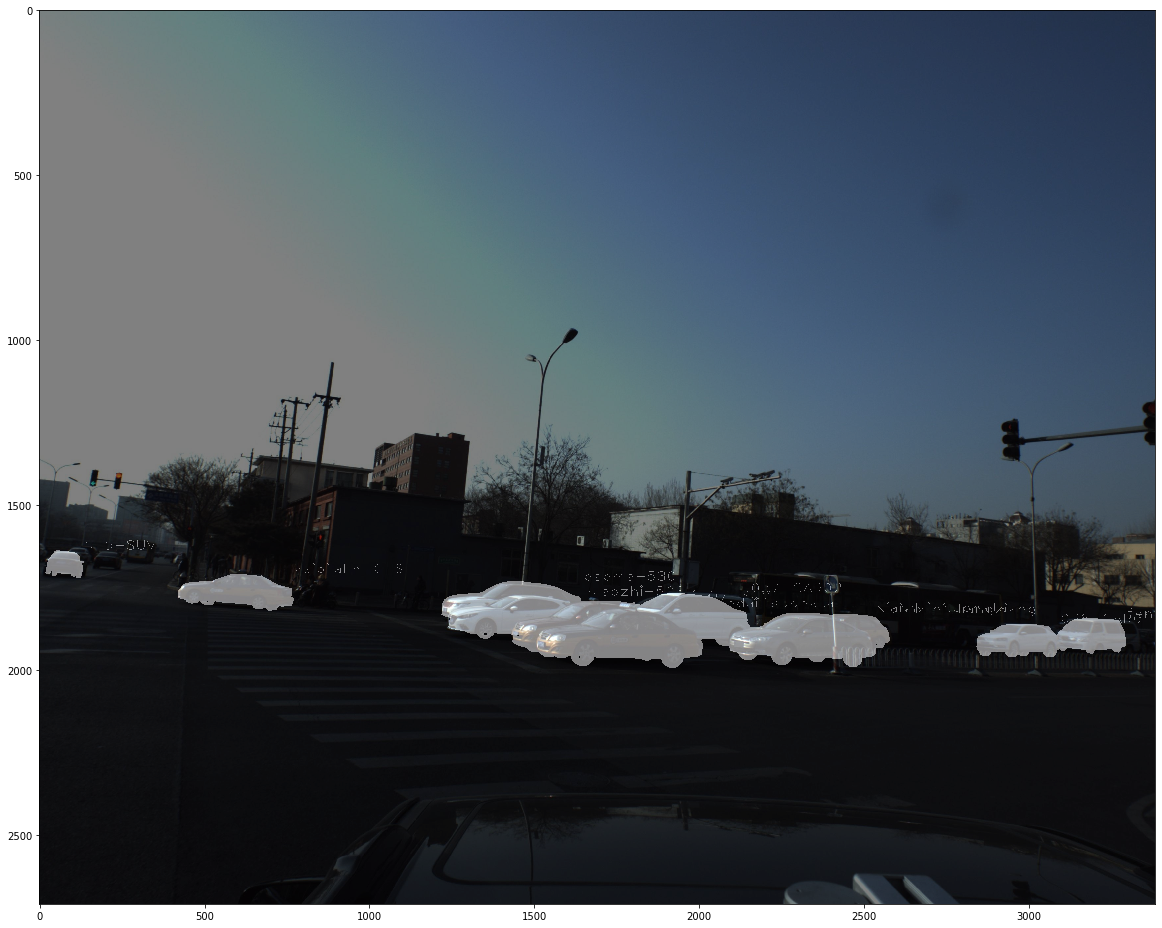

In [14]:
alpha = .5
img_with_mask = np.array(img)
cv2.addWeighted(cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR), alpha, img_with_mask, 1 - alpha, 0, img_with_mask)
plt.figure(figsize=(20,20))
plt.imshow(img_with_mask);

In [144]:
cv2.imwrite(img_name + "_masked.png", img_with_mask[:, :, ::-1])

True

In [32]:
cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

(2710, 3384, 3)

In [34]:
model_types

['28',
 '60',
 '35',
 '28',
 '28',
 '31',
 '47',
 '47',
 '46',
 '16',
 '16',
 '46',
 '16',
 '16',
 '2',
 '6',
 '16']

In [21]:
len(car_id2model[28]['vertices'])

4234

In [22]:
car_id2name[28]

'leikesasi'

In [23]:
import pickle

In [26]:
with open('/disks/hdd/pku-autonomous-driving/car_models/leikesasi.pkl', "rb") as f:
    data = pickle.load(f)

AttributeError: Can't get attribute 'CHJ_tiny_obj' on <module 'objloader' from '/home/ivb/miniconda3/envs/pku/lib/python3.7/site-packages/objloader/__init__.py'>

In [ ]:
yaws, pitches, rolls

In [40]:
yaws

['0.0840923',
 '0.0840923',
 '0.0840923',
 '0.0840923',
 '0.0840923',
 '0.0840923',
 '0.0840923',
 '0.0840923']

In [41]:
train.head()

ImageId                                   PredictionString
0  ID_8a6e65317  16 0.254839 -2.57534 -3.10256 7.96539 3.20066 ...
1  ID_337ddc495  66 0.163988 0.192169 -3.12112 -3.17424 6.55331...
2  ID_a381bf4d0  43 0.162877 0.00519276 -3.02676 2.1876 3.53427...
3  ID_7c4a3e0aa  43 0.126957 -3.04442 -3.10883 -14.738 24.6389 ...
4  ID_8b510fad6  37 0.16017 0.00862796 -3.0887 -3.04548 3.4977 ...

In [43]:
train['PredictionString'].map(lambda x: x.split())

0       [16, 0.254839, -2.57534, -3.10256, 7.96539, 3....
1       [66, 0.163988, 0.192169, -3.12112, -3.17424, 6...
2       [43, 0.162877, 0.00519276, -3.02676, 2.1876, 3...
3       [43, 0.126957, -3.04442, -3.10883, -14.738, 24...
4       [37, 0.16017, 0.00862796, -3.0887, -3.04548, 3...
                              ...                        
4257    [70, 0.177583, -0.023215, -3.08003, -25.3682, ...
4258    [12, 0.23817, -3.12745, 3.13929, -7.21988, 3.0...
4259    [35, 0.166437, -0.497963, -3.12063, 12.6792, 5...
4260    [70, 0.14292, 0.0290822, -3.12594, -3.42749, 3...
4261    [35, 0.166939, 3.08081, -3.11637, -14.8892, 6....
Name: PredictionString, Length: 4262, dtype: object

In [191]:
train = pd.read_csv('/disks/hdd/pku-autonomous-driving/train.csv')

def f(x):
    x = x.split()
    model_types, yaws, pitches, rolls, xs, ys, zs = [x[i::7] for i in range(7)]
    model_types = list(map(int, model_types))
    yaws = list(map(float, yaws))
    pitches = list(map(float, pitches))
    rolls = list(map(float, rolls))
    xs = list(map(float, xs))
    ys = list(map(float, ys))
    zs = list(map(float, zs))
    return dict(
        model_types=model_types, 
        yaws=yaws, pitches=pitches, rolls=rolls, 
        xs=xs, ys=ys, zs=zs
    )

In [192]:
train["parsed"] = train['PredictionString'].map(f)
train = train.drop("PredictionString", axis=1).set_index("ImageId")

In [193]:
train.head()

parsed
ImageId                                                        
ID_8a6e65317  {'model_types': [16, 56, 70, 70, 46], 'yaws': ...
ID_337ddc495  {'model_types': [66, 60, 28, 66, 46, 70, 2, 50...
ID_a381bf4d0  {'model_types': [43, 51, 35, 18, 8, 35, 16, 46...
ID_7c4a3e0aa  {'model_types': [43, 46, 46], 'yaws': [0.12695...
ID_8b510fad6  {'model_types': [37, 40, 51, 54, 66, 16, 66, 2...

In [194]:
train.to_dict()["parsed"]

{'ID_8a6e65317': {'model_types': [16, 56, 70, 70, 46],
  'yaws': [0.254839, 0.181647, 0.163072, 0.141942, 0.163068],
  'pitches': [-2.57534, -1.46947, -1.56865, -3.1395, -2.08578],
  'rolls': [-3.10256, -3.12159, -3.11754, 3.11969, -3.11754],
  'xs': [7.96539, 9.60332, 10.39, -9.59236, 9.83335],
  'ys': [3.20066, 4.66632, 11.2219, 5.13662, 13.2689],
  'zs': [11.0225, 19.339, 59.7825, 24.7337, 72.9323]},
 'ID_337ddc495': {'model_types': [66, 60, 28, 66, 46, 70, 2, 50],
  'yaws': [0.163988,
   0.112482,
   0.186114,
   0.0209679,
   0.195428,
   0.195568,
   0.112481,
   0.112334],
  'pitches': [0.192169,
   -2.96307,
   0.35728,
   0.218402,
   -2.84778,
   2.13627,
   0.504593,
   0.406024],
  'rolls': [-3.12112,
   3.13951,
   -3.10043,
   3.12213,
   -3.13394,
   -3.13969,
   3.13951,
   3.13547],
  'xs': [-3.17424,
   -14.7269,
   -7.49818,
   -10.3531,
   -22.7711,
   -44.5869,
   -24.6755,
   -22.1187],
  'ys': [6.55331,
   10.2077,
   10.3112,
   11.2453,
   13.0704,
   11.2091,


In [92]:
train.loc[9]

ImageId                                                  ID_2ad1fc1b3
PredictionString    28 0.1514 0.0071941 -3.10048 2.94173 8.31218 4...
Name: 9, dtype: object

In [93]:
train.loc[13]

ImageId                                                  ID_f0fca07ab
PredictionString    37 0.12618 -3.12722 -3.09636 -10.0779 4.67114 ...
Name: 13, dtype: object

In [131]:
train.loc[54]

ImageId                                                  ID_688d64128
PredictionString    35 0.143315 1.99388 -3.06204 0.722272 5.08504 ...
Name: 54, dtype: object